In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install tensorflow==2.12

In [3]:
!pip install nltk

# Importing Necessary Libraries:

In [4]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.layers import Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap

plt.rcParams['font.size'] = 12
sns.set_style("dark")
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [5]:
image_path = '/kaggle/input/coco-2017-dataset/coco2017/train2017'

# IMAGE DIRECTORY

In [6]:
import os

image_path = '/kaggle/input/coco-2017-dataset/coco2017/train2017'

# Get the list of files in the directory
file_list = os.listdir(image_path)

# Count the number of images
num_images = len(file_list)
print(f"Number of images in train2017: {num_images}")

Number of images in train2017: 118287


# LOADING THE JSON FILE 

In [7]:
import json

# Open the captions_train2017.json file
with open('/kaggle/input/coco-2017-dataset/coco2017/annotations/captions_train2017.json', 'r') as f:
    data = json.load(f)
    data = data['annotations']
# Check the number of captions
num_captions = len(data)
print(f"Number of captions in captions_train2017: {num_captions}")

Number of captions in captions_train2017: 591753


# IMAGE CAPTION CONNECTION

the image-caption pairs are created based on the annotations data from the captions_train2017.json file. The image name (img_name) is generated using the image ID from each annotation, and the corresponding caption is extracted from the sample dictionary.

The image paths are then formatted using the image_path variable, which specifies the path to the train2017 directory. This ensures that each image is connected to its corresponding caption by creating the full file path for each image.

In [8]:
img_cap_pairs = []

# Iterate over each annotation in the data
for sample in data:
    img_name = '%012d.jpg' % sample['image_id']
    img_cap_pairs.append([img_name, sample['caption']])

# Create a DataFrame from the image-caption pairs
data = pd.DataFrame(img_cap_pairs, columns=['image', 'caption'])

# Format the image paths
data['image'] = data['image'].apply(
    lambda x: f'/kaggle/input/coco-2017-dataset/coco2017/train2017/{x}'
)

# Sample 40,000 captions
data = data.sample(40000)

# Reset the DataFrame index
data = data.reset_index(drop=True)

# Print the first few rows of the DataFrame
data.head()   

image  \
0  /kaggle/input/coco-2017-dataset/coco2017/train...   
1  /kaggle/input/coco-2017-dataset/coco2017/train...   
2  /kaggle/input/coco-2017-dataset/coco2017/train...   
3  /kaggle/input/coco-2017-dataset/coco2017/train...   
4  /kaggle/input/coco-2017-dataset/coco2017/train...   

                                             caption  
0  Passengers sit and stand in front of a shop in...  
1  A stuffed animal sits on grass, next to an ope...  
2                     a large air plane on a run way  
3    The man is standing in front of the glass door.  
4  There is a blue and yellow bus stopped with th...

# Visualization 
* Images and their corresponding captions

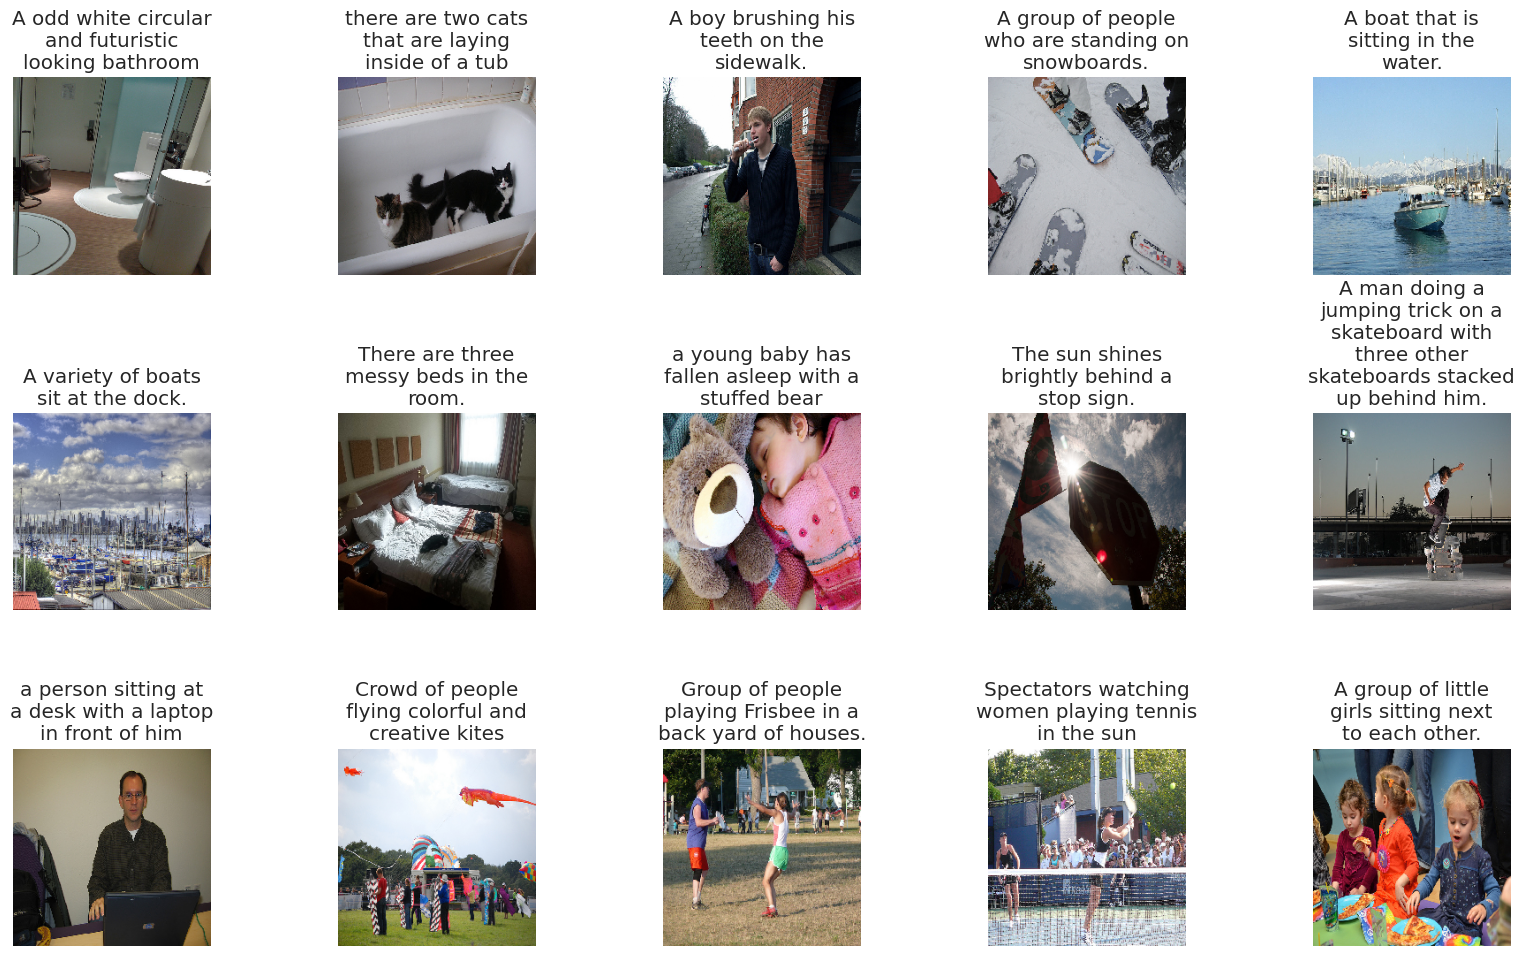

In [9]:
def readImage(path, img_size=224):
    # Construct the full image path by joining the base directory path with the image filename
    img_path = os.path.join('/kaggle/input/coco-2017-dataset/coco2017/train2017', os.path.basename(path))
    
    # Load the image, convert it to an array, and normalize the pixel values
    img = load_img(img_path, color_mode='rgb', target_size=(img_size, img_size))
    img = img_to_array(img)
    img = img / 255.0

    return img

def display_images(temp_df):
    # Reset the index of the DataFrame
    temp_df = temp_df.reset_index(drop=True)
    
    # Create a figure with a specified size
    plt.figure(figsize=(20, 20))
    
    n = 0
    for i in range(15):
        n += 1
        
        # Create a subplot and adjust the spacing between subplots
        plt.subplot(5, 5, n)
        plt.subplots_adjust(hspace=0.7, wspace=0.3)
        
        # Load and display the image
        image = readImage(f"/kaggle/input/coco-2017-dataset/coco2017/train2017/{temp_df.image[i]}")
        plt.imshow(image)
        
        # Wrap the caption text to a maximum of 20 characters per line and set it as the title of the subplot
        plt.title("\n".join(wrap(temp_df.caption[i], 20)))
        
        # Turn off the axis
        plt.axis("off")

# Call the display_images() function with a sample of 15 rows from the 'captions' DataFrame
display_images(data.sample(15))

# TEXT PREPROCESSING

In [10]:
import re
def text_preprocessing(data):
    # Convert captions to lowercase
    data['caption'] = data['caption'].apply(lambda x: x.lower())
    
    # Remove non-alphabetic characters
    data['caption'] = data['caption'].apply(lambda x: re.sub("[^A-Za-z]", " ", x))
    
    # Replace multiple whitespaces with a single whitespace
    data['caption'] = data['caption'].apply(lambda x: re.sub("\s+", " ", x))
    
    # Remove words with length less than or equal to 1
    data['caption'] = data['caption'].apply(lambda x: " ".join([word for word in x.split() if len(word) > 1]))
    
    # Add start and end tokens to captions
    data['caption'] = "startseq " + data['caption'] + " endseq"
    
    return data

# Preprocessed Text

In [11]:
data = text_preprocessing(data)
captions = data['caption'].tolist()
captions[:10]

['startseq passengers sit and stand in front of shop in the train terminal endseq',
 'startseq stuffed animal sits on grass next to an open photo album endseq',
 'startseq large air plane on run way endseq',
 'startseq the man is standing in front of the glass door endseq',
 'startseq there is blue and yellow bus stopped with the words book bus on it endseq',
 'startseq an old beige building with clock tower in the background endseq',
 'startseq man rides surf board under the curl of wave endseq',
 'startseq dog is relaxing on bed beside pillows endseq',
 'startseq blurry foreground suggests counter top with food bearing items while the majority of the shot shows rippling expanse of water and person standing on surfboard and using long oar to move away from shore endseq',
 'startseq bathroom with sink and toilet endseq']

# Tokenization and Encoded Representation 
* The words in a sentence are separated/tokenized and encoded in a one hot representation
* These encodings are then passed to the embeddings layer to generate word embeddings

In [12]:
# Create a tokenizer and fit it on the captions
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)

# Determine the vocabulary size
vocab_size = len(tokenizer.word_index) + 1

# Find the maximum caption length
max_length = max(len(caption.split()) for caption in captions)

# Get the unique image names
images = data['image'].unique().tolist()
nimages = len(images)

# Split the images into train and test sets
split_index = round(0.85 * nimages)
train_images = images[:split_index]
test_images = images[split_index:]

# Create train and test dataframes
train = data[data['image'].isin(train_images)].reset_index(drop=True)
test = data[data['image'].isin(test_images)].reset_index(drop=True)

# Convert a caption to a sequence of integers using the tokenizer
sample_caption = captions[1]
sequence = tokenizer.texts_to_sequences([sample_caption])[0]

# Print the resulting sequence
print(sequence)

[1, 239, 376, 92, 3, 63, 19, 11, 13, 130, 180, 4080, 2]


In [45]:
# mới thêm
def define_model(vocab_size, max_length):
    input1 = Input(shape=(1920,))
    input2 = Input(shape=(max_length,))
    img_features = Dense(256, activation='relu')(input1)
    img_features_reshaped = Reshape((1, 256), input_shape=(256,))(img_features)
    sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2)
    merged = concatenate([img_features_reshaped, sentence_features], axis=1)
    sentence_features = LSTM(256)(merged)
    x = Dropout(0.5)(sentence_features)
    x = add([x, img_features])
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(vocab_size, activation='softmax')(x)
    model = Model(inputs=[input1, input2], outputs=output)
    return model

# Image Feature Extraction
* DenseNet 201 Architecture is used to extract the features from the images
* Any other pretrained architecture can also be used for extracting features from these images
* Since the Global Average Pooling layer is selected as the final layer of the DenseNet201 model for our feature extraction, our image embeddings will be a vector of size 1920

In [15]:
# Create a DenseNet201 model
model = DenseNet201()

# Create a feature extraction model by taking the output from the second last layer of the DenseNet201 model
fe = Model(inputs=model.input, outputs=model.layers[-2].output)

# Set the image size
img_size = 224

# Create a dictionary to store the image features
features = {}

# Iterate over the unique image paths in your COCO dataset
for image in tqdm(data['image'].unique().tolist()):
    # Construct the image path by joining the base directory with the image name
    img_path = os.path.join('/kaggle/input/coco-2017-dataset/coco2017/train2017', os.path.basename(image))
    
    # Load and preprocess the image using load_img and img_to_array functions
    img = load_img(img_path, target_size=(img_size, img_size))
    img = img_to_array(img)
    
    # Normalize the image pixel values to the range of [0, 1]
    img = img / 255.0
    
    # Expand the dimensions of the image array to match the model's input shape
    img = np.expand_dims(img, axis=0)
    
    # Extract the features by passing the preprocessed image through the feature extraction model (fe) using the predict method
    feature = fe.predict(img, verbose=0)
    
    # Store the extracted features in a dictionary with the image path as the key
    features[image] = feature

100%|██████████| 34968/34968 [56:00<00:00, 10.41it/s]  


# Data Generation 
* Since Image Caption model training like any other neural network training is a highly resource utillizing process we cannot load the data into the main memory all at once, and hence we need to generate the data in the required format batch wise
* The inputs will be the image embeddings and their corresonding caption text embeddings for the training process
* The text embeddings are passed word by word for the caption generation during inference time

In [17]:
class CustomDataGenerator(Sequence):
    
    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer, 
                 vocab_size, max_length, features, shuffle=True):
    
        self.df = df.copy()  # Create a copy of the dataframe
        self.X_col = X_col  # Column name for image filenames
        self.y_col = y_col  # Column name for captions
        self.directory = directory  # Directory where images are located
        self.batch_size = batch_size  # Batch size
        self.tokenizer = tokenizer  # Tokenizer object
        self.vocab_size = vocab_size  # Vocabulary size
        self.max_length = max_length  # Maximum caption length
        self.features = features  # Dictionary of image features
        self.shuffle = shuffle  # Shuffle flag
        self.n = len(self.df)  # Number of samples in the dataframe
        
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)  # Shuffle the dataframe
    
    def __len__(self):
        return self.n // self.batch_size  # Compute the number of batches
    
    def __getitem__(self, index):
    
        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size, :]
        X1, X2, y = self.__get_data(batch)  # Get data for the current batch      
        return (X1, X2), y
    
    def __get_data(self, batch):
        
        X1, X2, y = list(), list(), list()
        
        images = batch[self.X_col].tolist()
           
        for image in images:
            feature = self.features[image]
            feature = np.reshape(feature, (1920,))  # Reshape image feature
            
            captions = batch.loc[batch[self.X_col] == image, self.y_col].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)
            
        X1, X2, y = np.array(X1), np.array(X2), np.array(y)
        return X1, X2, y
    
    


# Size of Any Random Image

In [18]:
from PIL import Image

# Open the image
image = Image.open("/kaggle/input/coco-2017-dataset/coco2017/train2017/000000000030.jpg")

# Get the size of the image
width, height = image.size
print("Image size:", width, "x", height)

Image size: 640 x 428


# Modelling 
* The image embedding representations are concatenated with the first word of sentence ie. starseq and passed to the LSTM network
* The LSTM network starts generating words after each input thus forming a sentence at the end

In [20]:
input1 = Input(shape=(1920,))
input2 = Input(shape=(max_length,))

img_features = Dense(256, activation='relu')(input1)
img_features_reshaped = Reshape((1, 256), input_shape=(256,))(img_features)

sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2)
merged = concatenate([img_features_reshaped,sentence_features],axis=1)
sentence_features = LSTM(256)(merged)
x = Dropout(0.5)(sentence_features)
x = add([x, img_features])
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(vocab_size, activation='softmax')(x)

caption_model = Model(inputs=[input1,input2], outputs=output)
caption_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [21]:
from tensorflow.keras.utils import plot_model

# Model Modification 
* A slight change has been made in the original model architecture to push the performance. The image feature embeddings are added to the output of the LSTMs and then passed on to the fully connected layers


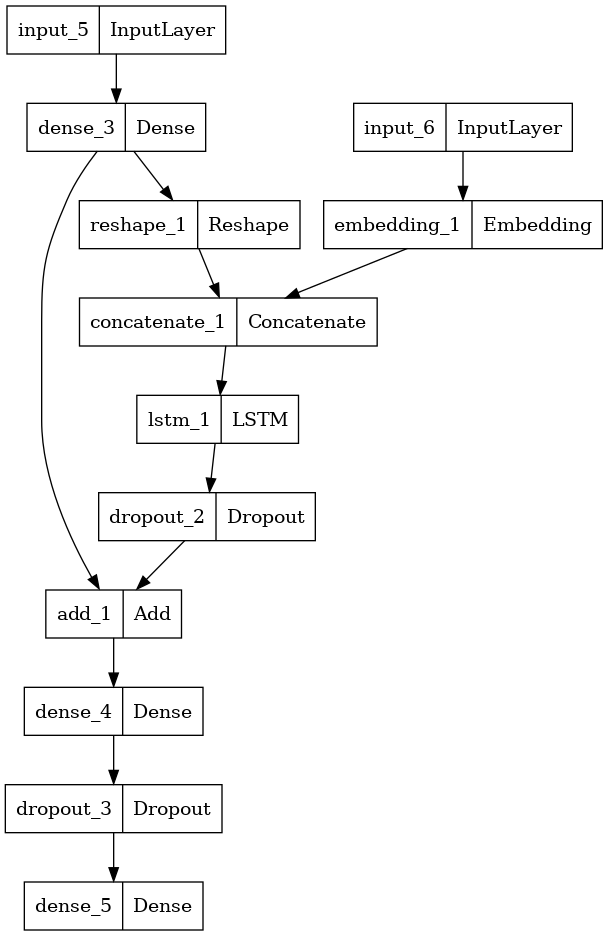

In [22]:
plot_model(caption_model)

# MODEL SUMMARY

In [23]:
caption_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 1920)]       0           []                               
                                                                                                  
 dense_3 (Dense)                (None, 256)          491776      ['input_5[0][0]']                
                                                                                                  
 input_6 (InputLayer)           [(None, 49)]         0           []                               
                                                                                                  
 reshape_1 (Reshape)            (None, 1, 256)       0           ['dense_3[0][0]']                
                                                                                            

In [34]:
# Create a custom data generator for training data
train_generator = CustomDataGenerator(df=train, X_col='image', y_col='caption', batch_size=64, directory='image_path',
                                      tokenizer=tokenizer, vocab_size=vocab_size, max_length=max_length, features=features)

# Create a custom data generator for validation data
validation_generator = CustomDataGenerator(df=test, X_col='image', y_col='caption', batch_size=64, directory='image_path',
                                      tokenizer=tokenizer, vocab_size=vocab_size, max_length=max_length, features=features)

In [49]:
model_name = "model.h5"

# Model checkpoint to save the best model based on validation loss
checkpoint = ModelCheckpoint(model_name, monitor="val_loss", mode="min", save_best_only=True, verbose=1)

# Early stopping to stop training if validation loss does not improve after certain epochs
earlystopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, restore_best_weights=True)

# Learning rate reduction to reduce learning rate if validation loss plateaus
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, factor=0.2, min_lr=0.00000001)

In [ ]:
import tensorflow as tf
tf.config.run_functions_eagerly(True)

# Let's train the Model!

In [ ]:
#caption_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#history = caption_model.fit(
#    train_generator,  # Training data generator
#    epochs=50,  # Number of epochs for training
#    validation_data=validation_generator,  # Validation data generator
#    callbacks=[checkpoint, earlystopping, learning_rate_reduction]  # List of callback functions
#)

In [ ]:
print(history.history.keys())


# ACCURACY AND LOSS PLOTS

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=[20, 8])

# Summarize history for accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy', size=25, pad=20)
plt.ylabel('Accuracy', size=15)
plt.xlabel('Epoch', size=15)
plt.legend(['train', 'test'], loc='upper left')

# Summarize history for loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss', size=25, pad=20)
plt.ylabel('Loss', size=15)
plt.xlabel('Epoch', size=15)
plt.legend(['train', 'test'], loc='upper left')

plt.show()

# Caption Generation Utility Function 

In [26]:
def idx_to_word(integer,tokenizer):
    
    for word, index in tokenizer.word_index.items():
        if index==integer:
            return word
    return None

## BLEU

In [ ]:
#def predict_caption(model, image, tokenizer, max_length, features):
 #   feature = features[image]
 #   in_text = "startseq"
 #   for i in range(max_length):
 #       sequence = tokenizer.texts_to_sequences([in_text])[0]
  #      sequence = pad_sequences([sequence], max_length)

  #      y_pred = model.predict([feature,sequence])
   #     y_pred = np.argmax(y_pred)

   #     word = idx_to_word(y_pred, tokenizer)

   #     if word is None:
   #         break

   #     in_text += " " + word

  #      if word == 'endseq':
   #         break

#    final_caption = in_text.replace('startseq ', '').replace(' endseq', '')
 #   return final_caption


In [27]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
tf.get_logger().setLevel('ERROR')

In [38]:
# Use 1/10 of the data for faster training
train_subset = train.sample(frac=0.5, random_state=42).reset_index(drop=True)
test_subset = test.sample(frac=0.2, random_state=42).reset_index(drop=True)

In [40]:
from nltk.translate.bleu_score import sentence_bleu

Training with params: {'batch_size': 32, 'epochs': 20, 'learning_rate': 0.001}
Epoch 1/20
540/541 [============================>.] - ETA: 0s - loss: 5.4446 - accuracy: 0.1567
Epoch 1: val_loss improved from inf to 4.68672, saving model to model.h5
541/541 [==============================] - 37s 60ms/step - loss: 5.4433 - accuracy: 0.1568 - val_loss: 4.6867 - val_accuracy: 0.2185 - lr: 0.0010
Epoch 2/20
540/541 [============================>.] - ETA: 0s - loss: 4.6151 - accuracy: 0.2295
Epoch 2: val_loss improved from 4.68672 to 4.35029, saving model to model.h5
541/541 [==============================] - 22s 40ms/step - loss: 4.6146 - accuracy: 0.2295 - val_loss: 4.3503 - val_accuracy: 0.2582 - lr: 0.0010
Epoch 3/20
540/541 [============================>.] - ETA: 0s - loss: 4.2979 - accuracy: 0.2575
Epoch 3: val_loss improved from 4.35029 to 4.15111, saving model to model.h5
541/541 [==============================] - 20s 38ms/step - loss: 4.2979 - accuracy: 0.2576 - val_loss: 4.1511 - va

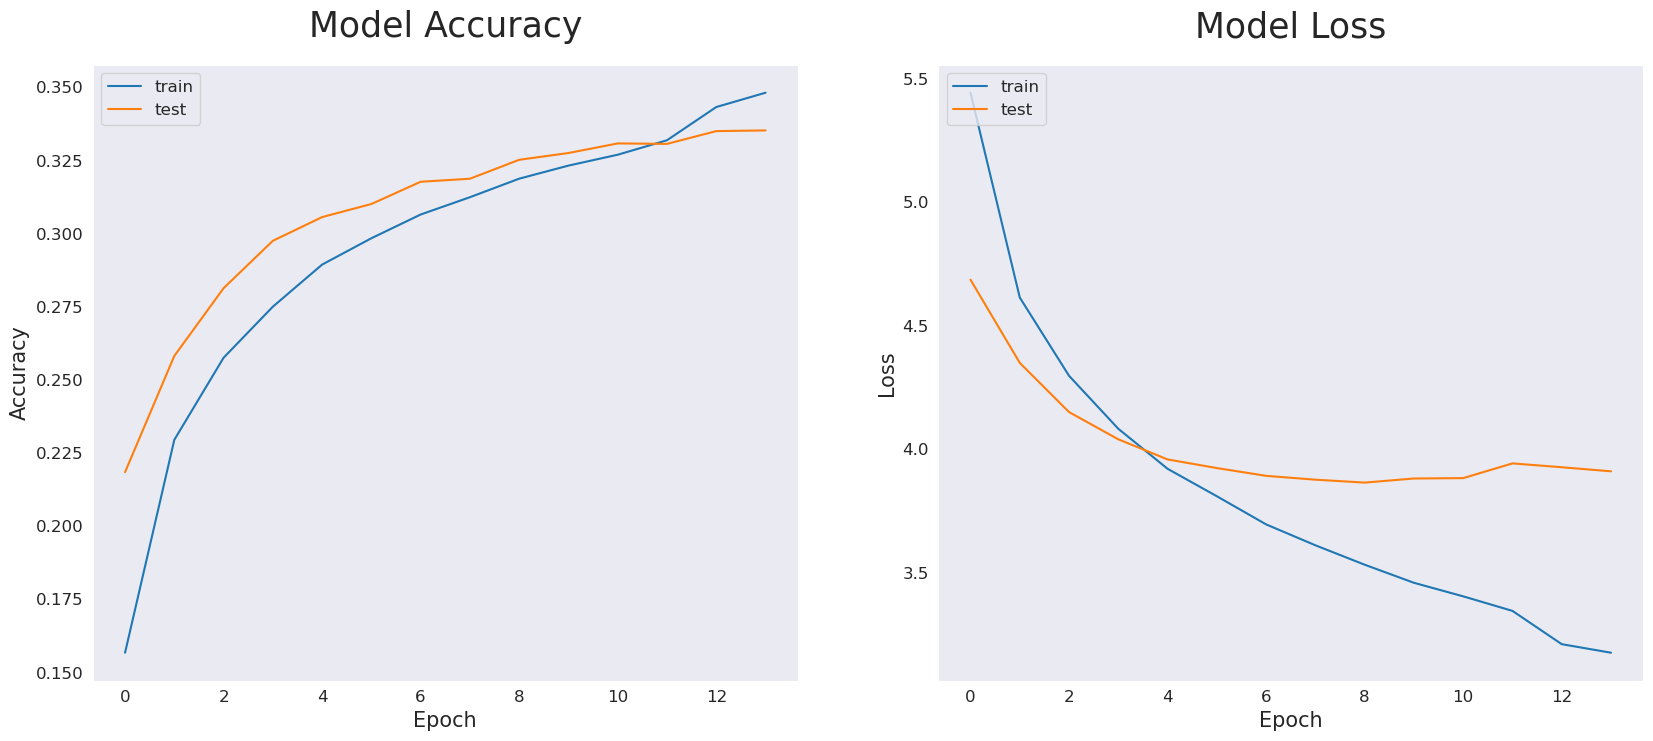

Training with params: {'batch_size': 64, 'epochs': 20, 'learning_rate': 0.001}
Epoch 1/20
270/270 [==============================] - ETA: 0s - loss: 5.6496 - accuracy: 0.1334
Epoch 1: val_loss did not improve from 3.86575
270/270 [==============================] - 34s 115ms/step - loss: 5.6496 - accuracy: 0.1334 - val_loss: 4.8460 - val_accuracy: 0.1963 - lr: 0.0010
Epoch 2/20
270/270 [==============================] - ETA: 0s - loss: 4.7047 - accuracy: 0.2154
Epoch 2: val_loss did not improve from 3.86575
270/270 [==============================] - 21s 77ms/step - loss: 4.7047 - accuracy: 0.2154 - val_loss: 4.4185 - val_accuracy: 0.2412 - lr: 0.0010
Epoch 3/20
270/270 [==============================] - ETA: 0s - loss: 4.3669 - accuracy: 0.2469
Epoch 3: val_loss did not improve from 3.86575
270/270 [==============================] - 20s 73ms/step - loss: 4.3669 - accuracy: 0.2469 - val_loss: 4.2188 - val_accuracy: 0.2715 - lr: 0.0010
Epoch 4/20
270/270 [==============================] -

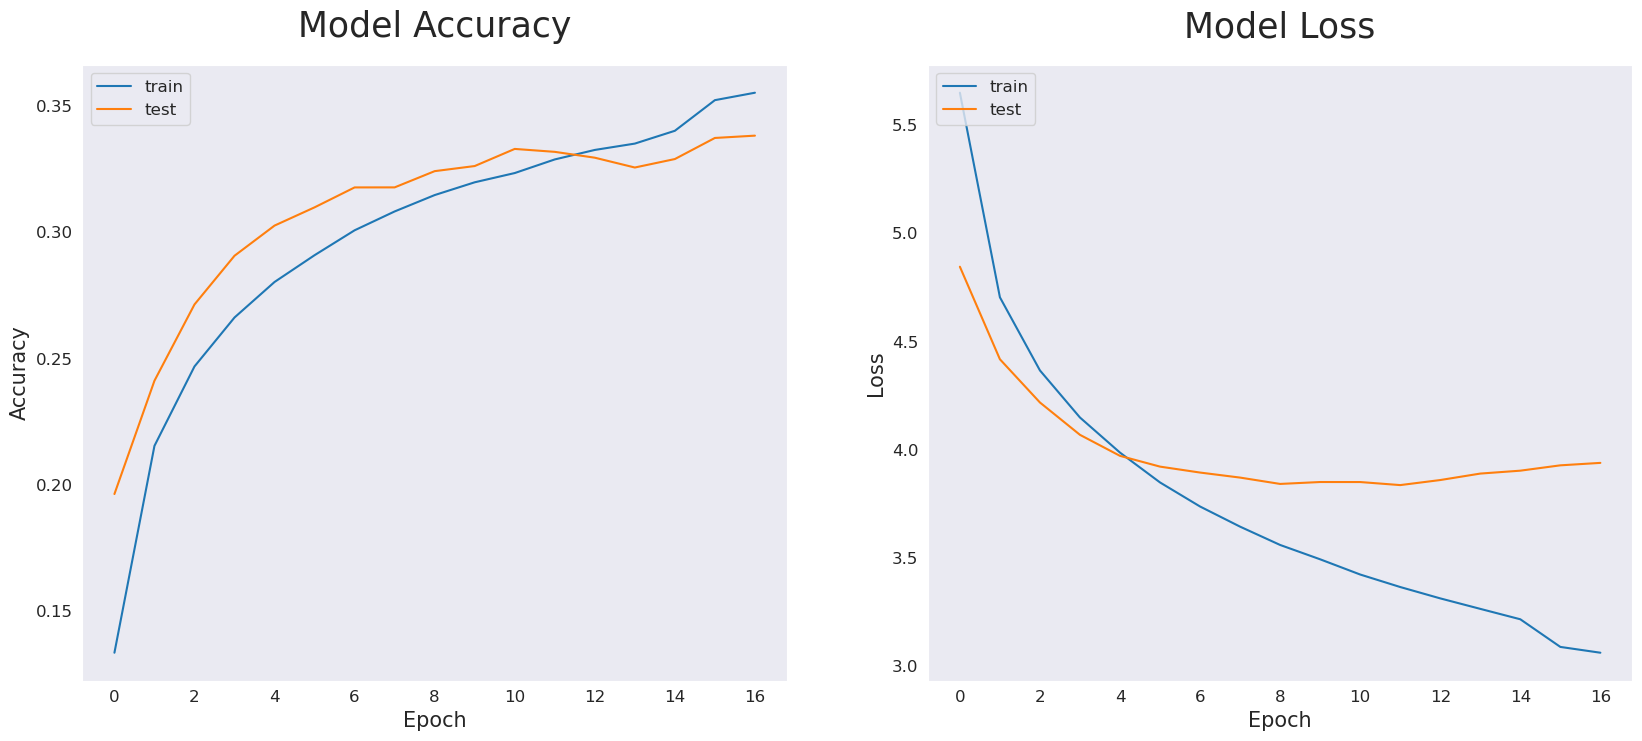

Training with params: {'batch_size': 32, 'epochs': 50, 'learning_rate': 0.001}
Epoch 1/50
541/541 [==============================] - ETA: 0s - loss: 5.4334 - accuracy: 0.1554
Epoch 1: val_loss did not improve from 3.83727
541/541 [==============================] - 30s 51ms/step - loss: 5.4334 - accuracy: 0.1554 - val_loss: 4.7092 - val_accuracy: 0.2201 - lr: 0.0010
Epoch 2/50
540/541 [============================>.] - ETA: 0s - loss: 4.6221 - accuracy: 0.2293
Epoch 2: val_loss did not improve from 3.83727
541/541 [==============================] - 19s 36ms/step - loss: 4.6214 - accuracy: 0.2294 - val_loss: 4.3713 - val_accuracy: 0.2547 - lr: 0.0010
Epoch 3/50
540/541 [============================>.] - ETA: 0s - loss: 4.3068 - accuracy: 0.2561
Epoch 3: val_loss did not improve from 3.83727
541/541 [==============================] - 21s 39ms/step - loss: 4.3062 - accuracy: 0.2562 - val_loss: 4.1649 - val_accuracy: 0.2799 - lr: 0.0010
Epoch 4/50
541/541 [==============================] - 

Training with params: {'batch_size': 64, 'epochs': 50, 'learning_rate': 0.001}
Epoch 1/50
270/270 [==============================] - ETA: 0s - loss: 5.6575 - accuracy: 0.1325
Epoch 1: val_loss did not improve from 3.83727
270/270 [==============================] - 29s 98ms/step - loss: 5.6575 - accuracy: 0.1325 - val_loss: 4.8297 - val_accuracy: 0.1952 - lr: 0.0010
Epoch 2/50
270/270 [==============================] - ETA: 0s - loss: 4.7290 - accuracy: 0.2141
Epoch 2: val_loss did not improve from 3.83727
270/270 [==============================] - 20s 74ms/step - loss: 4.7290 - accuracy: 0.2141 - val_loss: 4.4460 - val_accuracy: 0.2452 - lr: 0.0010
Epoch 3/50
270/270 [==============================] - ETA: 0s - loss: 4.4014 - accuracy: 0.2448
Epoch 3: val_loss did not improve from 3.83727
270/270 [==============================] - 20s 75ms/step - loss: 4.4014 - accuracy: 0.2448 - val_loss: 4.2466 - val_accuracy: 0.2669 - lr: 0.0010
Epoch 4/50
270/270 [==============================] - 

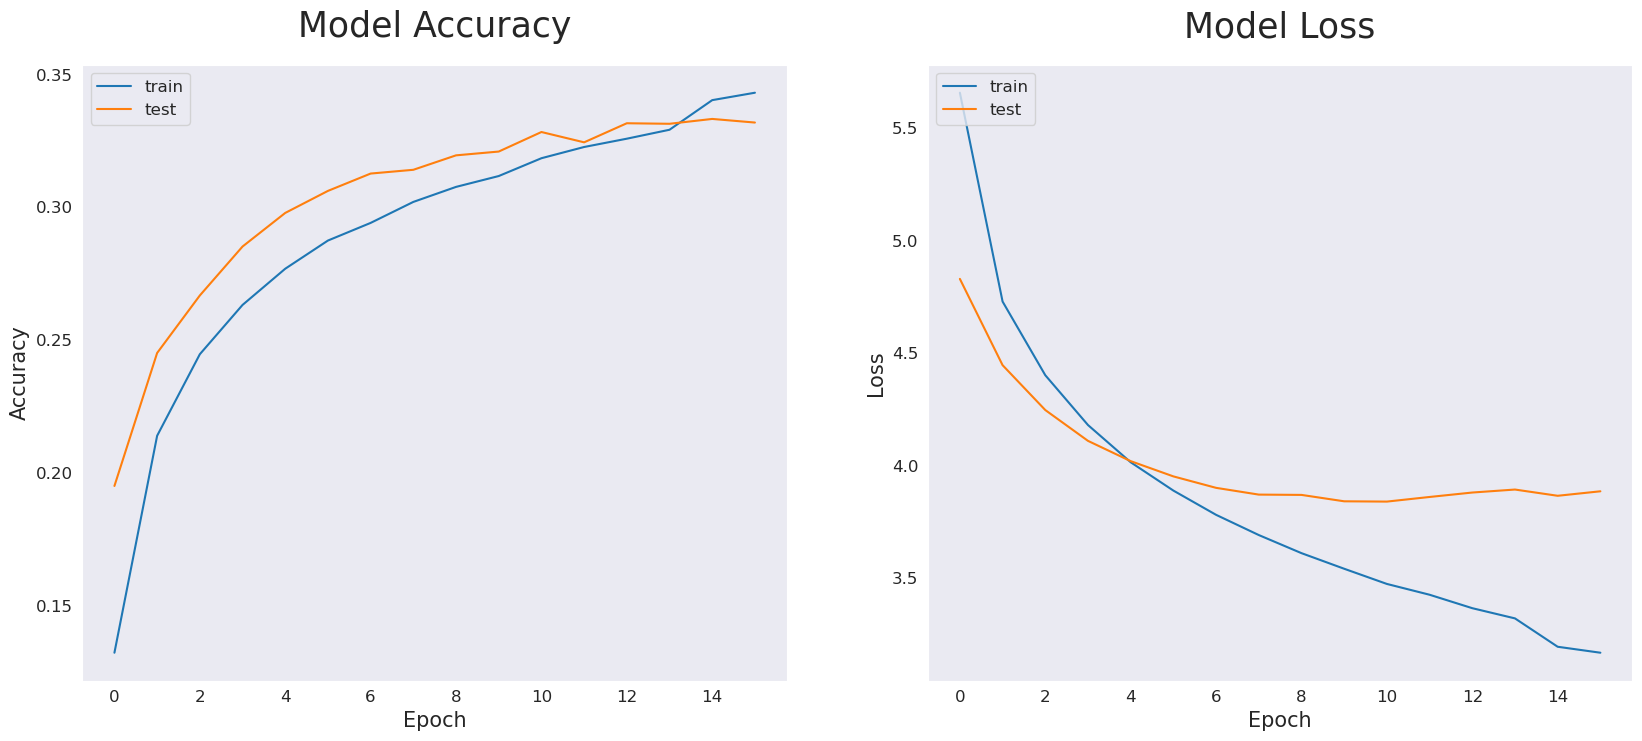

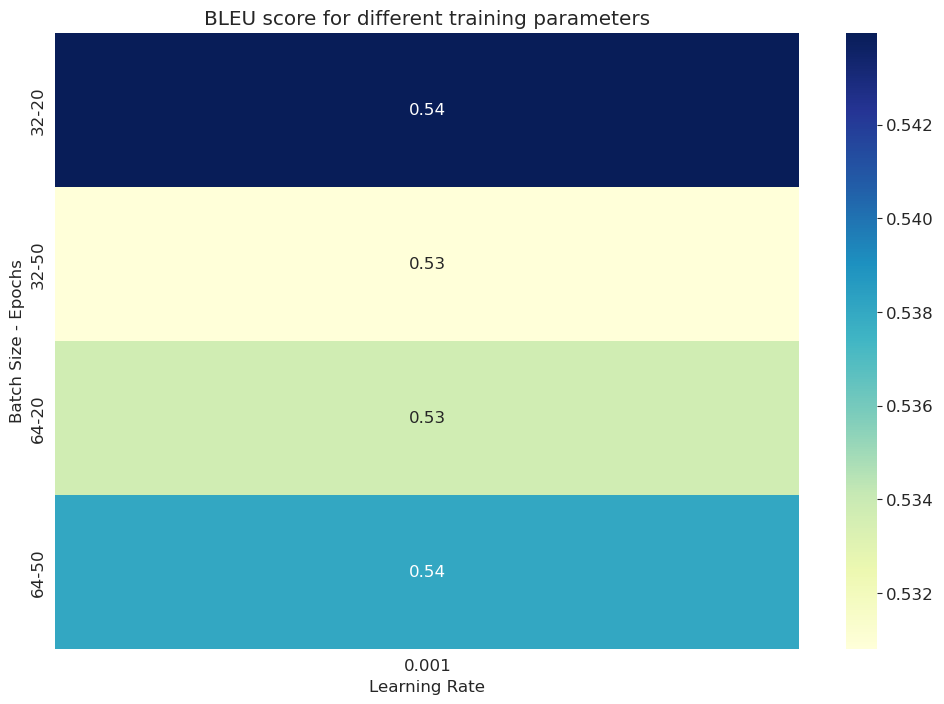

Best parameters: {'batch_size': 32, 'epochs': 20, 'learning_rate': 0.001} with BLEU score: 0.5439612086002263


In [50]:
def predict_caption(model, image, tokenizer, max_length, features):
    feature = features[image]
    in_text = "startseq"
    for _ in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)
        y_pred = model.predict([feature, sequence], verbose=0)
        y_pred = np.argmax(y_pred)
        word = idx_to_word(y_pred, tokenizer)
        if word is None:
            break
        in_text += " " + word
        if word == 'endseq':
            break
    return in_text 

def calculate_bleu(reference, candidate):
    return sentence_bleu([reference], candidate)

def calculate_bleu_scores(model):
    references = []
    candidates = []
    
    for _, record in test_subset.iterrows():
        reference_captions = record['caption'].split()
        references.append(reference_captions)
        
        predicted_caption = predict_caption(model, record['image'], tokenizer, max_length, features).split()
        candidates.append(predicted_caption)
    
    bleu_scores = []
    for ref, cand in zip(references, candidates):
        score = calculate_bleu(ref, cand)
        bleu_scores.append(score)
    
    return np.mean(bleu_scores)

def train_model(train_params):
    train_generator = CustomDataGenerator(df=train_subset, X_col='image', y_col='caption', batch_size=train_params['batch_size'], 
                                          directory='image_path', tokenizer=tokenizer, vocab_size=vocab_size, 
                                          max_length=max_length, features=features)

    validation_generator = CustomDataGenerator(df=test_subset, X_col='image', y_col='caption', batch_size=train_params['batch_size'], 
                                               directory='image_path', tokenizer=tokenizer, vocab_size=vocab_size, 
                                               max_length=max_length, features=features)

    caption_model = define_model(vocab_size, max_length)

    optimizer = Adam(learning_rate=train_params['learning_rate'])
    caption_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    history = caption_model.fit(
        train_generator,
        epochs=train_params['epochs'],
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping, learning_rate_reduction],
        verbose=1
    )
    
    return caption_model, history

# Hyperparameters
train_params_list = [
    {'batch_size': 32, 'epochs': 20, 'learning_rate': 0.001},
    {'batch_size': 64, 'epochs': 20, 'learning_rate': 0.001},
    {'batch_size': 32, 'epochs': 50, 'learning_rate': 0.001},
    {'batch_size': 64, 'epochs': 50, 'learning_rate': 0.001},
]

results = []

for params in train_params_list:
    print(f"Training with params: {params}")
    model, history = train_model(params)
    avg_bleu_score = calculate_bleu_scores(model)
    results.append((params, avg_bleu_score))

    # Plot training history
    plt.figure(figsize=[20, 8])

    # Summarize history for accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy', size=25, pad=20)
    plt.ylabel('Accuracy', size=15)
    plt.xlabel('Epoch', size=15)
    plt.legend(['train', 'test'], loc='upper left')

    # Summarize history for loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss', size=25, pad=20)
    plt.ylabel('Loss', size=15)
    plt.xlabel('Epoch', size=15)
    plt.legend(['train', 'test'], loc='upper left')

    plt.show()

batch_sizes = sorted(set(p['batch_size'] for p, s in results))
epochs_list = sorted(set(p['epochs'] for p, s in results))
learning_rates = sorted(set(p['learning_rate'] for p, s in results))

heatmap_data = np.zeros((len(batch_sizes) * len(epochs_list), len(learning_rates)))
param_map = {}

for i, batch_size in enumerate(batch_sizes):
    for j, epochs in enumerate(epochs_list):
        for k, learning_rate in enumerate(learning_rates):
            param_map[(batch_size, epochs, learning_rate)] = (i * len(epochs_list) + j, k)

for params, score in results:
    pos = param_map[(params['batch_size'], params['epochs'], params['learning_rate'])]
    heatmap_data[pos] = score

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, xticklabels=learning_rates, yticklabels=[f"{bs}-{ep}" for bs in batch_sizes for ep in epochs_list], cmap="YlGnBu")
plt.xlabel('Learning Rate')
plt.ylabel('Batch Size - Epochs')
plt.title('BLEU score for different training parameters')
plt.show()

best_params, best_score = max(results, key=lambda item: item[1])
print(f"Best parameters: {best_params} with BLEU score: {best_score}")

# 15 Random Samples for Caption Prediction 

In [59]:
samples = test.sample(15)
samples.reset_index(drop=True,inplace=True)

In [58]:
for index,record in samples.iterrows():

    img = load_img(os.path.join(image_path,record['image']),target_size=(224,224))
    img = img_to_array(img)
    img = img/255.
    
    caption = predict_caption(caption_model, record['image'], tokenizer, max_length, features)
    samples.loc[index,'caption'] = caption

# FINALLY, THE RESULT !!!

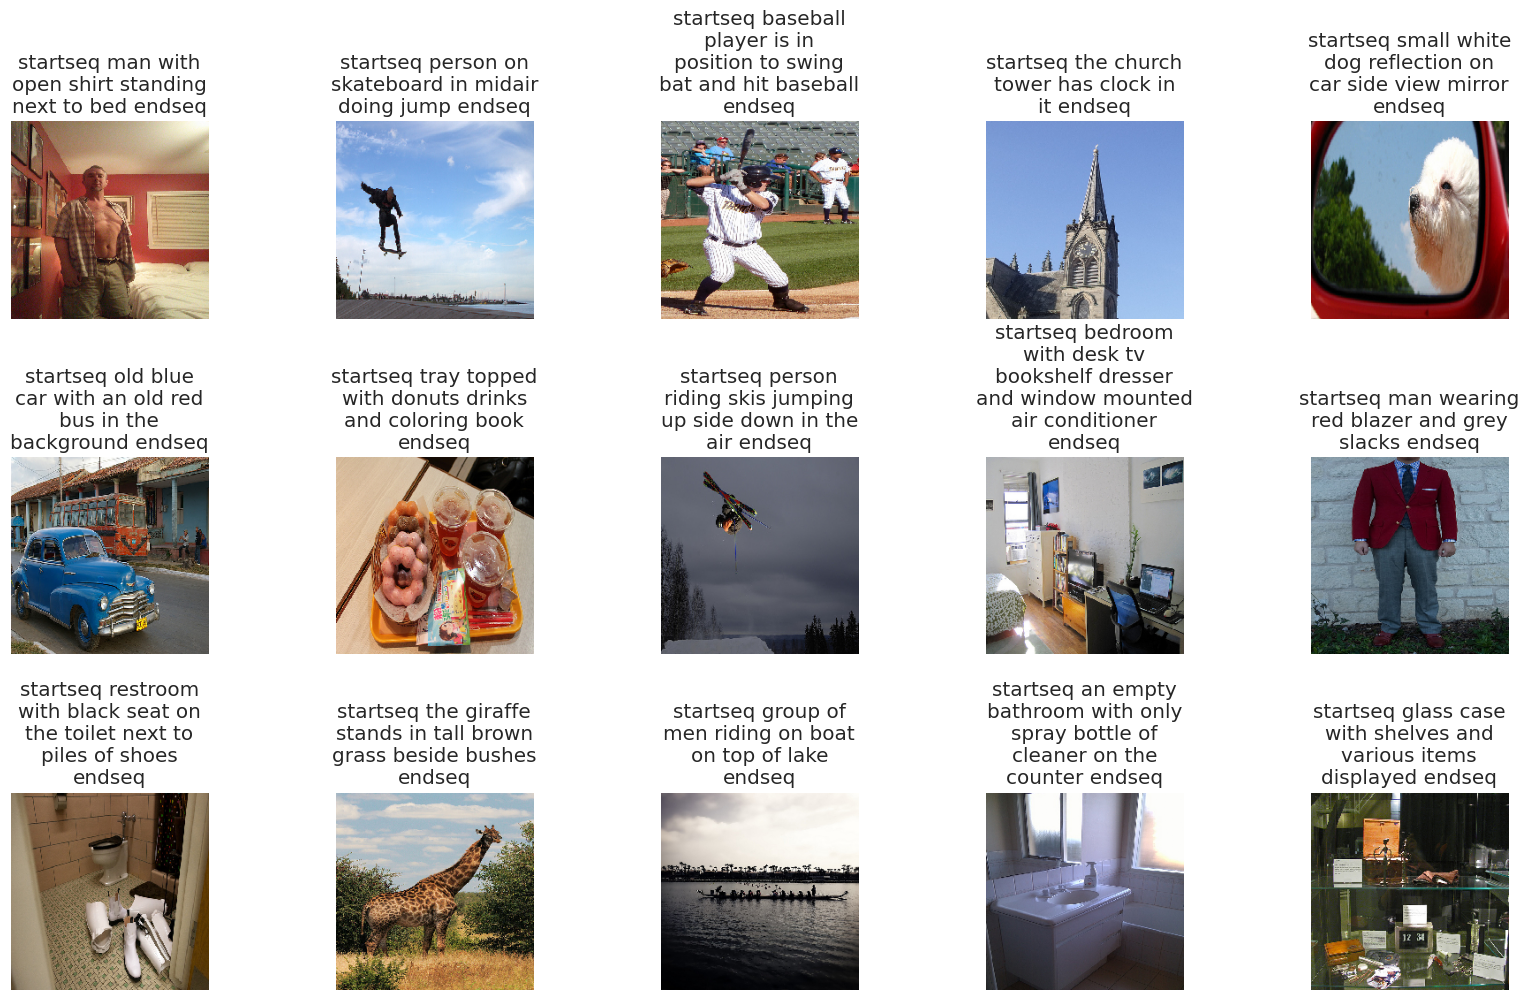

In [60]:
display_images(samples)